# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import seaborn as sns

# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import testing_utils as testing
import model_training_utils as model_train
import ensemble_model_utils as ensemble
import math
from datetime import datetime as dt
import re as re
import pickle as pk

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

In [3]:
# Load the pickle file that contains the clean data and other useful stuff?
infile = open('./clean_data_pickle','rb')
data = pk.load(infile)
infile.close()

with open('clean_test_data.pkl', 'rb') as infile:
    kaggle_test_data = pk.load(infile)

--------

# Cross Validation

We started with a simple 15% dev set, but we have found that for this amount of data, the differences in the models and their scores on the dev sets can vary significantly based on which rows end up in the train and dev sets. Repeated random sub-sampling cross validation helps us get more consistent results.

Note that we do not split out the dev data using the most recent years, which would be the proper way to create a dev set if our task were explicitly to predict future home prices. The test data appears to have rows from all the years represented in the train set, so we built dev sets that sample from across the train set. 

In [4]:
# still to do : choose one version of pandas to use so that our code all agrees
# and I don't have to read in a new dataset here 
NUM_CROSS_VALS = 1

In [5]:
# get the list of different cross val splits
cross_val_list = []
for i in range(NUM_CROSS_VALS):
    split_idx = int(data.shape[0] * .85)
    # line below is what shuffles
    data = data.sample(frac=1)
    train_df = data[:split_idx]
    dev_df = data[split_idx:]
    split_dict = {'train_df': train_df,
                  'dev_df': dev_df}
    cross_val_list.append(split_dict)

## Error Metric

As our primary error metric, we focus on the root mean squared error of the logarithm of the prices, which is the error metric being used to create the leaderboard for this kaggle competition. See rmsle() in shared_functions.py for our implementation of the root mean squared logarithmic error, an implementation we found from Mark Nagelberg on Kaggle: https://www.kaggle.com/marknagelberg/rmsle-function. Note that this adds 1 to each target and *marginally* inflates the underlying target. 

Note, however, that the rmsle is not necessarily the same error metric that is used consistently in all of the underlying models. In some cases minimizing another error metric may result in minimizing the rmsle (e.g. minimizing sum of squares will minimize root mean logarthmic error). But in other cases, such as the kNN, which minimizes Euclidean distance, it is not clear to us that it necessarily solves for rmsle. 


## Get Baseline

When we consulted our resident real estate expert, Hilary's dad, about this problem, he told us that only one of these factors matters - "location, location, location." In the spirit of that insight, we created a baseline "model" which looks at what neighborhood the house is in and takes the mean price of houses from that neighborhood in the training set. 

In [7]:
# todo: figure out why i'm getting nans now
# when i wasn't in original notebook
def baseline_pred(row,
                  train_df):
    for col in train_df:
        if 'Neighborhood' in col:
            if row[col] == 1:
                neighborhood_var = col
                break
    return np.nanmean(train_df[train_df[neighborhood_var]==1]['LogSalePrice'])

def get_baseline_cross_val(cross_val_list):
    all_rmses = []
    for di in cross_val_list:
        dev_df = di['dev_df']
        dev_df['baseline_pred'] = dev_df.apply(lambda row: baseline_pred(row,
                                                                         di['train_df']), axis=1)
        rmse = testing.rmsle(list(np.exp(dev_df['LogSalePrice'])), list(np.exp(dev_df['baseline_pred'])))
        all_rmses.append(rmse)
    return np.nanmean(all_rmses) 

# baseline RMSLE
print("Baseline RMSLE: {:.3f}".format(get_baseline_cross_val(cross_val_list)))

Baseline RMSLE: 0.284


/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With this as a baseline, we began exploring how different types of models perform on the problem.

## Model Exploration 
#### Linear Regression

We begin with linear regression as the standard choice for a regression problem. In ordinary least squares regression, the regression line is fit by minimizing the sum of squared residuals between the predicted line and the true data points. We can interpret the resulting coefficients on each feature as representing the additional impact of a one-unit change in that feature on the final price.

- Will not work well with variables that are highly correlated with each other (note that OneHotEncoding is technically not the right solution here as one category will be a linear combination of the others, but the model will drop it anyway).
- Indeed this is why linear regression with PCA seems to do just as well as the original variables since each principal component is orthogoal to one another the  loss is not as great for linear regression (only 0.04 loss in RMSLE).
- We find that the simple, unembellished linear regression is extremely effective relative to the baseline. With some simple hyperparameter tuning we find that the Lasso ultimately does best, as it allows us to remove entire features altogether- this suggests that we have too many (redundant) features, such as GarageCars and Garage SqFt. Indeed it makes sense then that the Ridge regression with an extremely large regularization parameter then does second best. The elasticnet which strikes a balance of the L1/L2 regularization seems to do worst.

In [121]:
# Set up different LR models
models_to_param_list = {LinearRegression: [{}], 
                        Lasso: [{'alpha': 0.001}], # lower value is less regularization
                        Ridge: [{'alpha': 50}], # more effective with more regularization
                        ElasticNet: [{'alpha': 0.005}]} # lower value is less regularization

# Outcome 
outcome_vars = ['LogSalePrice']

# Create feature sets
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']]]

# Output model
lr_models = model_train.try_different_models(cross_val_list, 
                                        models_to_param_list,
                                        outcome_vars, 
                                        feature_sets)

lr_models_forensemble = lr_models.sort_values('Root MSE', ascending=True)
lr_models_forensemble

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
1,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[Lasso(alpha=0.001, copy_X=True, fit_intercept...",232,LogSalePrice,{'alpha': 0.001},0.130500,0.117427
2,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[Ridge(alpha=50, copy_X=True, fit_intercept=Tr...",232,LogSalePrice,{'alpha': 50},0.134653,0.121234
3,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[ElasticNet(alpha=0.005, copy_X=True, fit_inte...",232,LogSalePrice,{'alpha': 0.005},0.137626,0.135933
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.146122,0.096617


### Bagging Illustration

Bagging, or bootstrap aggregation, is intended to reduce variance in the test error by averaging predictions over very specialized models. While each of these models in isolation is likely to overfit, the ensemble of specialized models ends up being very effective at reducing overall test error. To stress test this assumption, we run several random forest ensembles on models that are increasingly less likely to *individually* overfit. We find that the more likely each individual model is to overfit (either by enforcing a smaller minimum leaf, or by enforcing a higher split size), the lower the error of the ensemble as a whole. We suspect that this is because a large ensemble paired with high variance/low bias individual models gives the best of both worlds.

Note however that this phenomenon is not true when we increase the proportion of features used to split at each node (causing any given individual tree to be more likely to overfit). We aren't sure why - perhaps the choice of features increases signal in the underlying data while increasing the complexity of each tree, and the former may offset effects from the latter. 

Another interesting phenomenon is that the difference between the training and test error decreases as each individual model within the ensemble gets less complex. This is a sign of increasing bias in the underlying model, which makes sense, since each model is more likely to underfit since it has less underlying complexity. 

This analysis suggests that we ought to lean towards creating more complex individual trees (low bias); the higher variance that results from this ought be offset by the bootstrap aggregation procedure. We will use a grid search to find the optimal combination of parameters. 

In [26]:
# Initialize list of tests:
param_list = []

# Create list of parameter types
for min_leaf_size in range(10):
    param_list.append({'min_samples_leaf': min_leaf_size, 'n_estimators': 50})
    
for feature_prop in range(10):
    param_list.append({'max_features': feature_prop/10, 'n_estimators': 50})
                       
for split_size in range(11):
    param_list.append({'min_samples_split': split_size, 'n_estimators': 50})


In [30]:
# Run models to show the impact of bagging
### THIS TAKES A LONG TIME TO RUN
models_to_param_list = {RandomForestRegressor: param_list}
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']]]

# Run different random forests
df = model_train.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)

df_forensemble = df.sort_values('Root MSE', ascending=True)


Text(0.5,0.98,'Bagging with High Variance Models')

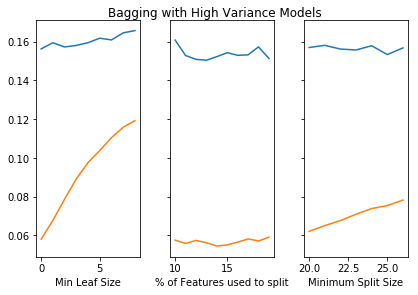

In [31]:
# Plot the data
fig, ax = plt.subplots(1,3, sharey='row')
fig.tight_layout(pad = 1.5)

ax[0].plot(df.iloc[0:9]['Root MSE'])
ax[0].plot(df.iloc[0:9]['Train MSE'])
ax[0].set_xlabel('Min Leaf Size')

ax[1].plot(df.iloc[10:20]['Root MSE'])
ax[1].plot(df.iloc[10:20]['Train MSE'])
ax[1].set_xlabel('% of Features used to split')

ax[2].plot(df.iloc[20:30]['Root MSE'])
ax[2].plot(df.iloc[20:30]['Train MSE'])
ax[2].set_xlabel('Minimum Split Size')

fig.suptitle('Bagging with High Variance Models')
# !!! remove the axis tick marks

### Boosting Illustration

In contrast, boosting is a process that reduces bias by refitting the model iteratively on the errors from the previous model. Boosting can turn weak learners into a accurate ensemble - we can see this below by showing how a relatively weak learner (tree of depth 3) actually appears to have the best accuracy in a GBM as compared to a GBM with greater depth. However, GBMs do have a tendency towards high variance (as seen by how quickly the model overfits the training data relative to the test data). 

In [33]:
# Initialize list of tests:
param_list = []
# Create list of parameter types
for depth in range(20):
    param_list.append({'max_depth': depth, 'n_estimators': 50})

In [35]:
# Run Gradient Boosting Results
models_to_param_list = {GradientBoostingRegressor: param_list}
df_boosting = model_train.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)
df_boosting_forensemble = df_boosting.sort_values('Root MSE', ascending=True)

Text(0,0.5,'Error')

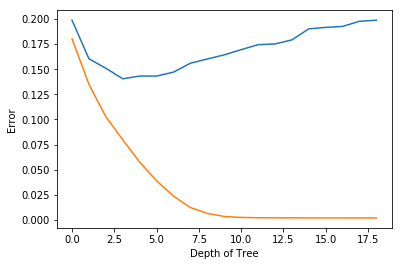

In [36]:
# Plot the DF Boosting Results.
plt.plot(df_boosting.index, df_boosting['Root MSE'])
plt.plot(df_boosting.index, df_boosting['Train MSE'])
plt.xlabel('Depth of Tree')

plt.ylabel('Error')

### Bayesian Ridge 
TODO EMILY

### KNearest Neighbors
TODO EMILY

### Other Models

### Ensembling Techniques

#### Voting & Avergaging

EMILY TODO

#### Stacking

We use stacking as a method of ensembling. Stacking involves training a meta-model on the underlying models. This is intended to give greater weights to models that are more accurate (instead of arbitrarily assigning weights to each or simple-averaging across them). The stacking model itself also need not be a linear model. We hypothesize that given a similar level of accuracy, models that generate predictions that are different from each other will do better in an ensemble, and this is also true of a stacked ensemble. To explore this idea we use a simple linear regression on the outputs of each of the given underlying models. 

By comparing several different models and plotting their predictions against in a scatterplot matrix, we see that:
- Not all models have a linear relationship with the final prediction: the boosted model appears to have more variation for any given level of the final prediction and tapers off at the end 
- Some models generate an extremely skewed data point (Linear Regression and RF) relative to the final regression. In the same vein the shape of the distribution for each model prediction can very substantially.
- However, the models are generally correlated with each other, suggesting that the ensemble of them may not be very successful (indeed this is what we find, the stacked ensemble does not perform much better)

This makes us think that a simple voting / averaging technique may be equally or more effective, and indeed we find that to be the case when we apply a simple weighting scheme across different model predictions. 

In [85]:
kagglepred = stack_ensemble(train_data = data,
                              dev_data = kaggle_test_data, 
                              model1 = get_best_specs_from_each_family(df_boosting), # boosting
                              model2 = get_best_specs_from_each_family(lr_models), # LR
                              model3 = get_best_specs_from_each_family(df),# bagging,
                              kaggle_flag = True) 

kagglepred2 = pd.concat([pd.DataFrame({'final_pred': kagglepred[0]}), kagglepred[1]], axis = 1)

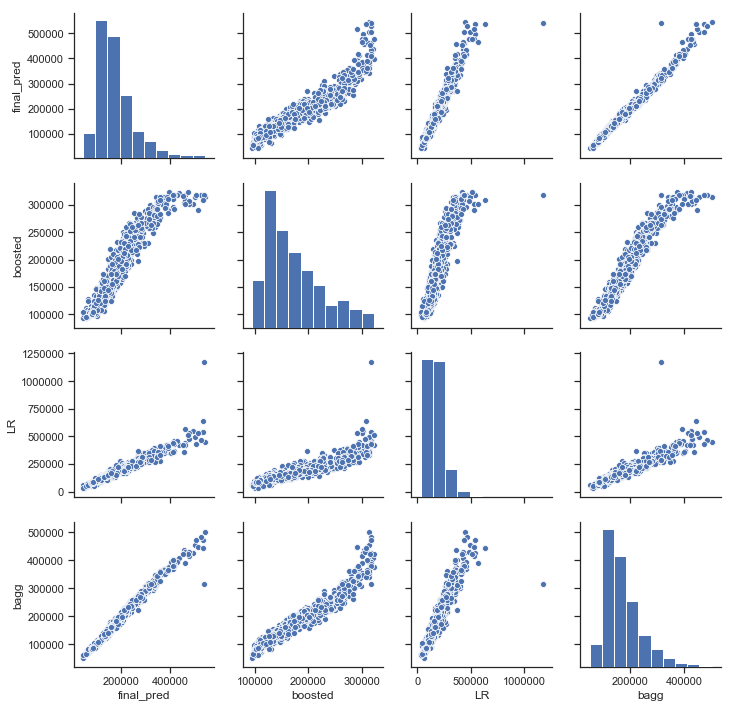

In [90]:
sns.set(style="ticks")
sns.pairplot(kagglepred2)


### Error Analysis

In this section, we'll go into more detail about how we actually iterated on models and chose whichever ones we end up deciding are our best. Our primary tools will be this error correlation table, which we'll use to look at patterns of errors the model is making, and diagnostics to determine whether or not the model is overfitting. We'll compare different models to each other and explain the model or ensemble that gives us the best results.

In [ ]:
# this still only works on individual models, it doens't average the correlations over a set of models
# this tool is really more exploratory than anything - look at a couple models from the set you care about
# and see what the trends are

# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
# use this variable to specify which in the list of models trained with that specification to use
model_to_use = df_and_row_to_use['Model'][1]
# don't change this
features_to_use = df_and_row_to_use['Features']

# table for our LR with all the features
corrs_df = testing.create_error_correlation_table(model_to_use, 'LogSalePrice', features_to_use, dev_df)
corrs_df.reindex(corrs_df.correlation.abs().sort_values(ascending=False).index)

#### Cycle through each model variation and plot errors

In [ ]:
### Random Forest
df.sort_values('Root MSE', ascending=True).head(1)

In [ ]:
### Linear Regression
lrdf.sort_values('Root MSE', ascending=True).head(1)

In [ ]:
### TODO YW: what do you want to use for feature importance here? save off the PCA feature importance
### from the last notebook?

### Random Forest Errors
rf_error_spec = df.sort_values('Root MSE', ascending=True).iloc[0]
model_to_use = rf_error_spec['Model'][0]
features_to_use = rf_error_spec['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

In [ ]:
### Linear Regression Errors
# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
features_to_use = df_and_row_to_use['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

# Final Model & Explanation

Different models will perform better on different numbers of features. For that reason, it seems worthwhile to try all the individual models we're using on different numbers of features. It will likely be advantageous to ensemble models trained on different numbers of features. 

We'll use feature importances, determined via random forest, in order to decide which features to use. It may also be worthwhile to try some other feature selection methods, or to try random selection. 

In [ ]:
feature_importances = pd.read_csv('feature_importance.csv')
feature_importances.columns = ['feature', 'importance']

In [ ]:
feature_sets_to_try = []

for i in range(1,24):
    set_to_try = list(feature_importances.feature.values)[:(i * 10)]
    set_to_try = [item for item in set_to_try if item not in ['SalePrice', 'LogSalePrice']]
    feature_sets_to_try.append(set_to_try)

In [ ]:
print(ensemble_to_use['Outcome_Vars'])

### Narrative of our process

In [ ]:
### discussion of the scikitlearn column - real working problem

### 1 Big Table

#### Comparing model performance across different number of features. 

# Messing Around

# YW

In [84]:
# Load Kaggle test set
def get_best_specs_from_each_family(family_df):
    model = family_df['Model'].iloc[0][0]
    return(model)

def change_to_saleprice(predictions):
    if np.mean(predictions) < 1000:
        return(np.exp(predictions))
    else:
        return(predictions)
    
def stack_ensemble(train_data, dev_data, model1, model2, model3, kaggle_flag):
    # Drop these columns in train
    dropcols_train = ['YrMoSold', 'SalePrice', 'LogSalePrice']
    
    # Assign workaround if kaggle_flag == True:
    if kaggle_flag == True:
        dropcols_dev = ['YrMoSold']
    else:
        dropcols_dev = ['YrMoSold', 'SalePrice', 'LogSalePrice', 'baseline_pred']

    # Get boosted predictions
    best_boosted_model = model1
    boosted_pred = best_boosted_model.predict(train_data.drop(columns=dropcols_train)) # how to include the cross validation here
    boosted_pred = change_to_saleprice(boosted_pred)
    
    boosted_test_pred = best_boosted_model.predict(dev_data.drop(columns=dropcols_dev))
    boosted_test_pred = change_to_saleprice(boosted_test_pred)
    
    # Get LR predictions
    best_LR_model = model2
    LR_pred = best_LR_model.predict(train_data.drop(columns=dropcols_train))
    LR_pred = change_to_saleprice(LR_pred)
    
    LR_test_pred = best_LR_model.predict(dev_data.drop(columns=dropcols_dev))
    LR_test_pred = change_to_saleprice(LR_test_pred)

    # Get bagged predictions
    best_bagg_model = model3
    bagg_pred = best_bagg_model.predict(train_data.drop(columns=dropcols_train))
    bagg_pred = change_to_saleprice(bagg_pred)

    bagg_test_pred = best_bagg_model.predict(dev_data.drop(columns=dropcols_dev))
    bagg_test_pred = change_to_saleprice(bagg_test_pred)

    # Create stacked model
    trainpred = pd.DataFrame(np.column_stack((boosted_pred, LR_pred, bagg_pred)), columns = ['boosted', 'LR', 'bagg'])
    testpred  = pd.DataFrame(np.column_stack((boosted_test_pred, LR_test_pred, bagg_test_pred)), columns = ['boosted', 'LR', 'bagg'])

    # Fit the ensemble parameters to fit the all the data
    ensemble_LR = LinearRegression()
    ensemble_LR.fit(trainpred, data['SalePrice'])
    finaltrainpred = ensemble_LR.predict(trainpred)

    # Fit the final predictions
    finaltestpred = ensemble_LR.predict(testpred)

    # Calculate the errgor (note this is the whole dataset so test/train are the same if you choose kaggle_flag == True)
    if kaggle_flag == True:
        error = testing.calculate_error(train_true = np.array(train_data['SalePrice']), 
                                train_pred = np.array(finaltrainpred),
                                test_true  = np.array(train_data['SalePrice']),
                                test_pred  = np.array(finaltrainpred),
                                outcome_var = 'SalePrice')
    else:
        error = testing.calculate_error(train_true = np.array(train_data['SalePrice']), 
                        train_pred = np.array(finaltrainpred),
                        test_true  = np.array(dev_data['SalePrice']),
                        test_pred  = np.array(finaltestpred),
                        outcome_var = 'SalePrice')


#     print(error)
#     print(np.mean(boosted_test_pred), np.mean(LR_test_pred), np.mean(bagg_test_pred))
#     print(np.mean(finaltestpred))
#     print(finaltestpred.shape)
    
    return [finaltestpred, testpred]

kagglepred = stack_ensemble(train_data = data,
                              dev_data = kaggle_test_data, # change this
                              model1 = get_best_specs_from_each_family(df_boosting), # boosting
                              model2 = get_best_specs_from_each_family(lr_models), # LR
                              model3 = get_best_specs_from_each_family(df),# bagging,
                              kaggle_flag = True) # Change this

# testing.make_kaggle_submission(list(kagglepred),
#                                kaggle_test_data,
#                                'tempsubmission.csv')

# EMILY 

### Linear Regression

In [ ]:
models_to_param_list = {LinearRegression: [{}]}
outcome_vars = ['LogSalePrice', 'SalePrice']
# for all models, we'll try with both the full feature set and the "top 10" feature set
lrdf = model_train.try_different_models(cross_val_list, 
                                        models_to_param_list,
                                        outcome_vars, 
                                        feature_sets_to_try)
lrdf.sort_values('Root MSE', ascending=True)

### Tree-based Models

In [ ]:
models_to_param_list = {DecisionTreeRegressor: [{}], 
                        RandomForestRegressor: [{'n_estimators': 10},
                                                {'min_samples_leaf': 3, 'n_estimators': 20}]}

df = model_train.try_different_models(cross_val_list, 
                                     models_to_param_list,
                                     outcome_vars, 
                                     feature_sets_to_try)
df.sort_values('Root MSE', ascending=True)

### Grab bag of other models - BR and KNN

In [ ]:
models_to_param_list = {BayesianRidge: [{}], 
                        KNeighborsRegressor: [{}]}

gb_df = model_train.try_different_models(cross_val_list, 
                                         models_to_param_list,
                                         outcome_vars, 
                                         feature_sets_to_try)
gb_df.sort_values('Root MSE', ascending=True)

In [ ]:
lin_models = ensemble.get_model_dicts_from_data_frame(lrdf.sort_values('Root MSE')[:5])
tree_models = ensemble.get_model_dicts_from_data_frame(df.sort_values('Root MSE')[:5])
bayesian_models = ensemble.get_model_dicts_from_data_frame(gb_df.sort_values('Root MSE')[:5])

In [ ]:
top_of_each = [models[0] for models in [lin_models, tree_models, bayesian_models]]
lin_and_tree = [models[0] for models in [lin_models, tree_models]]
lin_and_bayesian = [models[0] for models in [lin_models, bayesian_models]]
bayesian_and_tree = [models[0] for models in [bayesian_models, tree_models]]

In [ ]:
voting_ensembles_df = ensemble.try_different_voting_ensembles(cross_val_list,
                                                              [top_of_each,
                                                               lin_and_tree,
                                                               lin_and_bayesian,
                                                               bayesian_and_tree, 
                                                               tree_models,
                                                               lin_models,
                                                               bayesian_models,
                                                               tree_models[:2],
                                                               tree_models[:3],
                                                               tree_models[:4]])

In [ ]:
voting_ensembles_df.sort_values('RMSE for ensemble')

In [ ]:
# choose model - for now, just choosing the best one
ensemble_to_use = voting_ensembles_df.sort_values('RMSE for ensemble')[:1]

In [ ]:
## 2 steps for submitting to kaggle:
## retrain models on all data and get new preds
## then make the final submission CSV
final_preds = testing.retrain_on_all_data_and_get_final_preds(ensemble_to_use,
                                                              data,
                                                              kaggle_test_data)
testing.make_kaggle_submission(final_preds,
                               kaggle_test_data,
                               'tempsubmission.csv')